In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

/media/DData/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering


In [2]:
import sys
try:
    if path:
        raise Exception('changed')
except:
    path = True
    sys.path.append('../')

from src.god_model_generator import god_model_sample
from src.god_model_estimator import *
from src.compute_u import compute_u
from src.god_model_tools import evaluate_polynomial
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [66]:
def probability_x_given_pi_mu_from_u(m: int, x:int, pi: float, mu: int, u: np.ndarray) -> float:
    """ 
    Returns P(X=x | pi, mu) computed from u
    P(X=x | pi, mu) = pi^m sum_{d=0}^m [ (1-pi) / pi ]^d u[mu, x, d]
    
    Parameters
    ----------
    m : int
        Number of categories
    x : int
        Observed category
    pi : float
        Probability of error
    mu : int
        Supposed true category
    u : np.ndarray
        u coefficients computed with compute_u
    
    Returns
    -------
    float
        P(X=x | pi, mu)
    """
    p = pi**m * np.sum(((1-pi) / pi)**np.arange(m+1) * u[mu, x - 1, :])
    p_ = pi ** m * evaluate_polynomial(u[mu, x - 1], (1-pi) / pi)
    assert np.isclose(p, p_), f"p={p} != p_={p_}"
    assert 0 <= p <= 1, f"p={p} not in [0, 1]"
    return p

In [6]:
M = 5
u = compute_u(M)

In [7]:
%%time
for i in range(1, 6):
    for pi in [0.6, 0.7, 0.8, 0.9, 1.0]:
        xs = god_model_sample(m=5, mu=i, pi=pi, n_sample=1_000, seed=0)
        mu_hat, pi_hat, _ = estimate_mu_pi(m=5, data=xs, u=u)
        print(f"mu={i}, mu_hat={mu_hat}, pi_error {abs(pi - pi_hat):.2e}, {'O' if mu_hat == i else 'X'}")

mu=1, mu_hat=1, pi_error 1.20e-02, O
mu=1, mu_hat=1, pi_error 1.25e-03, O
mu=1, mu_hat=1, pi_error 4.63e-03, O
mu=1, mu_hat=1, pi_error 2.21e-03, O
mu=1, mu_hat=1, pi_error 3.34e-05, O
mu=2, mu_hat=2, pi_error 7.73e-04, O
mu=2, mu_hat=2, pi_error 5.60e-03, O
mu=2, mu_hat=2, pi_error 6.52e-03, O
mu=2, mu_hat=2, pi_error 7.72e-03, O
mu=2, mu_hat=2, pi_error 3.34e-05, O
mu=3, mu_hat=3, pi_error 3.66e-03, O
mu=3, mu_hat=3, pi_error 4.79e-03, O
mu=3, mu_hat=3, pi_error 5.79e-03, O
mu=3, mu_hat=3, pi_error 4.94e-03, O
mu=3, mu_hat=3, pi_error 3.34e-05, O
mu=4, mu_hat=4, pi_error 2.43e-03, O
mu=4, mu_hat=4, pi_error 6.30e-03, O
mu=4, mu_hat=4, pi_error 3.95e-03, O
mu=4, mu_hat=4, pi_error 7.49e-03, O
mu=4, mu_hat=4, pi_error 3.34e-05, O
mu=5, mu_hat=5, pi_error 3.59e-03, O
mu=5, mu_hat=5, pi_error 2.10e-04, O
mu=5, mu_hat=5, pi_error 8.37e-03, O
mu=5, mu_hat=5, pi_error 5.90e-03, O
mu=5, mu_hat=5, pi_error 3.34e-05, O
CPU times: user 32.4 s, sys: 19.7 ms, total: 32.4 s
Wall time: 32.5 s


In [8]:
%%time
for i in range(1, 6):
    for pi in [0.6, 0.7, 0.8, 0.9, 1.0]:
        xs = god_model_sample(m=5, mu=i, pi=pi, n_sample=1_000, seed=0)
        mu_hat, pi_hat, _ = estimate_mu_pi_grid(m=5, data=xs, nb_pi=100)
        print(f"mu={i}, mu_hat={mu_hat}, pi_error {abs(pi - pi_hat):.2e}, {'O' if mu_hat == i else 'X'}")

/media/Data/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/notebooks/../src/god_model_estimator.py:190: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(p)


mu=1, mu_hat=1, pi_error 1.11e-02, O
mu=1, mu_hat=1, pi_error 3.03e-03, O
mu=1, mu_hat=1, pi_error 7.07e-03, O
mu=1, mu_hat=1, pi_error 4.04e-03, O
mu=1, mu_hat=1, pi_error 0.00e+00, O
mu=2, mu_hat=2, pi_error 1.01e-03, O
mu=2, mu_hat=2, pi_error 8.08e-03, O
mu=2, mu_hat=2, pi_error 7.07e-03, O
mu=2, mu_hat=2, pi_error 6.06e-03, O
mu=2, mu_hat=2, pi_error 0.00e+00, O
mu=3, mu_hat=3, pi_error 6.06e-03, O
mu=3, mu_hat=3, pi_error 7.07e-03, O
mu=3, mu_hat=3, pi_error 7.07e-03, O
mu=3, mu_hat=3, pi_error 6.06e-03, O
mu=3, mu_hat=3, pi_error 0.00e+00, O
mu=4, mu_hat=4, pi_error 1.01e-03, O
mu=4, mu_hat=4, pi_error 8.08e-03, O
mu=4, mu_hat=4, pi_error 3.03e-03, O
mu=4, mu_hat=4, pi_error 6.06e-03, O
mu=4, mu_hat=4, pi_error 0.00e+00, O
mu=5, mu_hat=5, pi_error 6.06e-03, O
mu=5, mu_hat=5, pi_error 2.02e-03, O
mu=5, mu_hat=5, pi_error 7.07e-03, O
mu=5, mu_hat=5, pi_error 6.06e-03, O
mu=5, mu_hat=5, pi_error 0.00e+00, O
CPU times: user 1min 10s, sys: 3.88 ms, total: 1min 10s
Wall time: 1min 10s

In [138]:
for i in range(1, 6):
    for pi in [0.6, 0.7, 0.8, 0.9, 1.0]:
        xs = god_model_sample(m=5, mu=i, pi=pi, n_sample=1_000, seed=0)
        mu_hat, pi_hat, _ = estimate_mu_pi_grid(m=5, data=xs, nb_pi=100)
        mu_hat_knowing_pi = estimate_mu_given_pi(m=5, data=xs, pi=pi)
        print(f"mu={i}, mu_hat={mu_hat}, argmax P(X | mu) {mu_hat_knowing_pi} = mu ? {'Y' if mu_hat_knowing_pi == i else 'N' * 10}, pi={pi}, pi_hat={pi_hat:.2f} {'O' if mu_hat == i else 'X'}")

/media/DData/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/tests/god_model_estimator.py:175: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(evaluate_polynomial(p=u_mu[x - 1], x=t))


mu=1, mu_hat=1, argmax P(X | mu) 1 = mu ? Y, pi=0.6, pi_hat=0.61 O
mu=1, mu_hat=1, argmax P(X | mu) 1 = mu ? Y, pi=0.7, pi_hat=0.70 O
mu=1, mu_hat=1, argmax P(X | mu) 1 = mu ? Y, pi=0.8, pi_hat=0.79 O
mu=1, mu_hat=1, argmax P(X | mu) 1 = mu ? Y, pi=0.9, pi_hat=0.90 O
mu=1, mu_hat=1, argmax P(X | mu) 1 = mu ? Y, pi=1.0, pi_hat=1.00 O
mu=2, mu_hat=2, argmax P(X | mu) 2 = mu ? Y, pi=0.6, pi_hat=0.60 O
mu=2, mu_hat=2, argmax P(X | mu) 2 = mu ? Y, pi=0.7, pi_hat=0.69 O
mu=2, mu_hat=2, argmax P(X | mu) 2 = mu ? Y, pi=0.8, pi_hat=0.79 O
mu=2, mu_hat=2, argmax P(X | mu) 2 = mu ? Y, pi=0.9, pi_hat=0.89 O
mu=2, mu_hat=2, argmax P(X | mu) 2 = mu ? Y, pi=1.0, pi_hat=1.00 O
mu=3, mu_hat=3, argmax P(X | mu) 3 = mu ? Y, pi=0.6, pi_hat=0.61 O
mu=3, mu_hat=3, argmax P(X | mu) 3 = mu ? Y, pi=0.7, pi_hat=0.71 O
mu=3, mu_hat=3, argmax P(X | mu) 3 = mu ? Y, pi=0.8, pi_hat=0.79 O
mu=3, mu_hat=3, argmax P(X | mu) 3 = mu ? Y, pi=0.9, pi_hat=0.89 O
mu=3, mu_hat=3, argmax P(X | mu) 3 = mu ? Y, pi=1.0, pi_hat=1.

In [140]:
for i in range(1, 6):
    for pi in [0.6, 0.7, 0.8, 0.9, 1.0]:
        xs = god_model_sample(m=5, mu=i, pi=pi, n_sample=1_000, seed=0)
        mu_hat, pi_hat, _ = estimate_mu_pi_torch(m=5, data=xs)
        mu_hat_knowing_pi = estimate_mu_given_pi(m=5, data=xs, pi=pi)
        print(f"mu={i}, mu_hat={mu_hat}, argmax P(X | mu) {mu_hat_knowing_pi} = mu ? {'Y' if mu_hat_knowing_pi == i else 'N' * 10}, pi={pi}, pi_hat={pi_hat:.2f} {'O' if mu_hat == i else 'X'}")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/theo/anaconda3/envs/ENV_3_9_15/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_26408/4279512873.py", line 4, in <module>
    mu_hat, pi_hat, _ = estimate_mu_pi_torch(m=5, data=xs)
  File "/media/DData/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/tests/god_model_estimator.py", line 567, in estimate_mu_pi_torch
    u = compute_u(m)
  File "/media/DData/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/tests/god_model_estimator.py", line 529, in optimize_log_likelihood
    optimizer.zero_grad()
  File "/media/DData/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/tests/god_model_estimator.py", line 495, in compute_log_likelihood_torch
AssertionError: Log-likelihood should be negative, but nan > 0

During handling of the above exception, another 

In [22]:
M = 5
u = compute_u(M)
mu = 2
PI = 0.9
xs = god_model_sample(m=M, mu=mu, pi=PI, n_sample=50, seed=0)
xs

array([2, 2, 2, 3, 2, 2, 2, 4, 2, 2, 1, 2, 2, 2, 1, 2, 2, 4, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, 2, 3, 2, 1, 2, 2, 4, 2, 2,
       2, 2, 2, 2, 2, 2])

In [7]:
estimate_mu_pi_grid(m=M, data=xs, nb_pi=100)

/media/DData/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/tests/god_model_estimator.py:183: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(evaluate_polynomial(p=u_mu[x - 1], x=t))


(2, 0.9242424242424243, -3.532365366698152)

In [8]:
estimate_mu_pi_grid(m=M, data=[2, 3], nb_pi=100, weights=[4/5, 1/5])

/media/DData/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/tests/god_model_estimator.py:188: RuntimeWarning: divide by zero encountered in log
  log_likelihood += weights[i] * np.log(evaluate_polynomial(p=u_mu[x - 1], x=t))


(2, 0.9242424242424243, -0.7064730733396305)

In [335]:
%%timeit
estimate_mu_pi_grid(m=M, data=xs, nb_pi=1_000)

/media/DData/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/tests/god_model_estimator.py:166: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(evaluate_polynomial(p=u_mu[x - 1], x=t))


1.23 s ± 23.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
log_likelihoods = grid_log_likelihood(m=M, data=xs, nb_pi=100, u=u, pi_min=0, pi_max=1)

In [76]:
def plot_log_likelihoods(m : int, mu: int, pi: float, u: np.ndarray, nb_pi: int = 1_000, data: np.ndarray = None, nb_sample: int = 100, seed: int=0) -> None:
    """"
    Plot the log-likelihoods P(X | pi, mu) over pi in [0, 1] for each mu in [1, m]

    Parameters
    ----------
    m : int
        Number of categories
    mu : int
        True category
    pi : float
        Probability of error
    u : np.ndarray
        u coefficients computed with compute_u
    nb_pi : int
        Number of points to plot
    data : np.ndarray
        Data observed if None the data are generated from the god model
    nb_sample : int
        Number of samples to generate from the god model if data is None
    seed : int
        Seed for the random number generator if data is None
    """
    assert 1 <= mu <= m, f"mu={mu} not in [1, m]"
    assert 0 <= pi <= 1, f"pi={pi} not in [0, 1]"
    assert u.shape == (m, m, m+1), f"u.shape={u.shape} != (m, m, m+1)"
    assert (data is None) ^ (nb_sample is None), f"data={data} and nb_sample={nb_sample} are not consistent"
    if data is None:
        data = god_model_sample(m=m, mu=mu, pi=pi, n_sample=nb_sample, seed=seed)
    log_likelihoods, pi_range = grid_log_likelihood(m=m, data=data, nb_pi=nb_pi, u=u, pi_min=0.5, pi_max=1)
    plt.figure(figsize=(10, 5))
    for i in range(1, m+1):
        plt.plot(pi_range, log_likelihoods[i - 1], label=f"mu={i}", linewidth=2 if i == mu else 1)

    plt.xlabel('pi')
    plt.ylabel('log likelihood')
    plt.axvline(pi, color='r', linestyle='--', label='pi')
    plt.title(f"True parameters m={m} mu={mu}, pi={pi}")
    plt.legend()

In [77]:
M = 5
u = compute_u(M)

/media/Data/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/notebooks/../src/god_model_estimator.py:190: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(p)


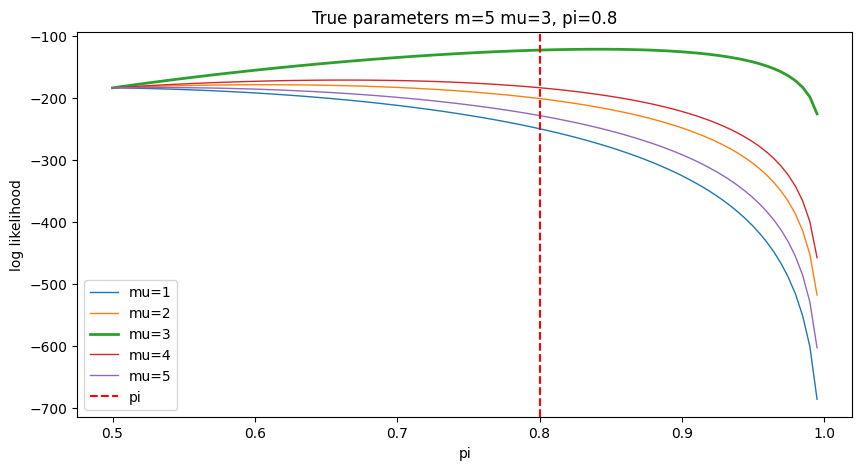

In [79]:
plot_log_likelihoods(m=M, mu=3, pi=0.8, u=u, nb_pi=100, nb_sample=100)

In [12]:
%%time
nb_point = 1_000
likelihoods = np.empty(nb_point)
abscisses = np.linspace(0, 1, nb_point)
for i, pi in enumerate(abscisses):
    likelihoods[i] = likelihood_distribution_xs_given_pi(m=5, data=xs, pi=pi)[mu - 1]
abscisses[likelihoods.argmax()]

CPU times: user 10.2 s, sys: 184 µs, total: 10.2 s
Wall time: 10.2 s


0.9029029029029029

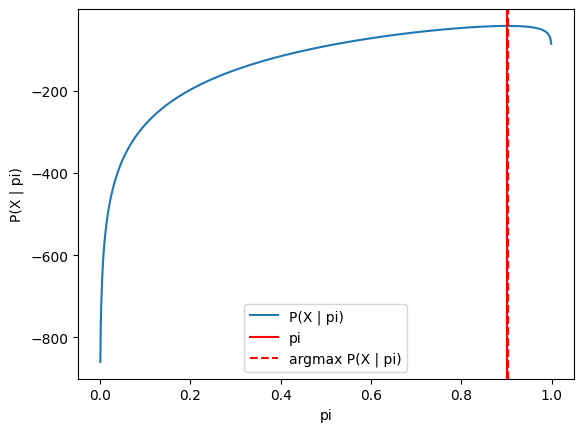

In [13]:
plt.plot(abscisses, likelihoods, label='P(X | pi) ')
plt.axvline(x=PI, color='r', label='pi')
plt.axvline(x=abscisses[likelihoods.argmax()], linestyle='--', color='r', label='argmax P(X | pi)')
plt.xlabel('pi')
plt.ylabel('P(X | pi)')
plt.legend()

In [17]:
%%time
nb_point = 1_000
likelihoods = np.empty(nb_point)
abscisses = np.linspace(0, 1, nb_point)
for i, pi in enumerate(abscisses):
    likelihoods[i] = compute_log_likelihood(m=5, data=xs, pi=pi, u_mu=u[mu - 1])
abscisses[likelihoods.argmax()]

/media/Data/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/notebooks/../src/god_model_estimator.py:177: RuntimeWarning: divide by zero encountered in scalar divide
  t = (1 - pi) / pi
/media/Data/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/notebooks/../src/god_model_estimator.py:191: RuntimeWarning: divide by zero encountered in log
  log_likelihood += weights[i] * np.log(


CPU times: user 536 ms, sys: 5 µs, total: 536 ms
Wall time: 535 ms


0.9029029029029029

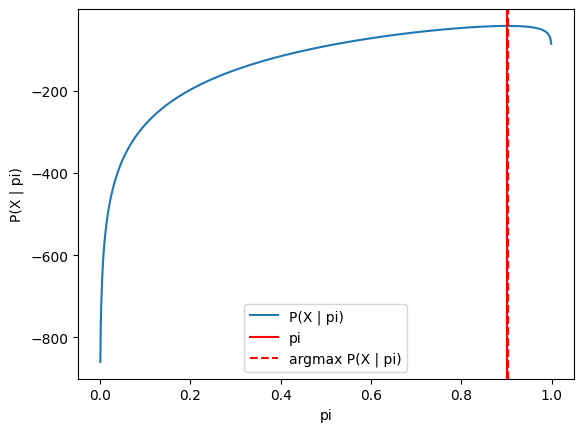

In [18]:
plt.plot(abscisses, likelihoods, label='P(X | pi) ')
plt.axvline(x=PI, color='r', label='pi')
plt.axvline(x=abscisses[likelihoods.argmax()], linestyle='--', color='r', label='argmax P(X | pi)')
plt.xlabel('pi')
plt.ylabel('P(X | pi)')
plt.legend()

In [322]:
mu_hat, pi_hat, ll, all_pis, all_lls = estimate_mu_pi(m=5, data=xs, pi_zero=0.7, n_iter_max=10, evolution=True)
mu_hat, pi_hat, ll

(3, 0.6541576019351939, -170.54125949158865)

In [325]:
all_lls[mu - 1]

[-116.47216730695854,
 -93.8656153616994,
 -90.48023425176959,
 -96.28393465495735,
 -106.63133708508208,
 -119.33045059125757,
 -133.28814801659558,
 -147.93379511540775,
 -162.9602486340026,
 -178.1990407867262,
 -193.55673042727082]

In [324]:
all_pis[mu - 1]

[0.7,
 0.8288319296960821,
 0.9040474240644942,
 0.9462928239285157,
 0.9698912654871437,
 0.9830941061269071,
 0.9904970626574114,
 0.9946547111009637,
 0.9969921372323651,
 0.9983070461798422,
 0.9990470075535007]

In [293]:
probability_distribution_xs_given_pi(M, xs, pi=0.6).argmax() + 1

2

In [295]:
likelihood_distribution_xs_given_pi(M, xs, pi=0.6).argmax() + 1

2

In [211]:
p = u[0, 4]
pi = 0.5623323468237743


array([0.        , 0.        , 0.83333333, 3.33333333, 3.5       ,
       1.        ])

In [214]:
probability_x_given_pi_mu_from_u(m=5, x=5, pi=pi, mu=1, u=u)

0.1824

In [ ]:
pi = 0.5623323468237743

evaluate_polynomial()

In [86]:
u = compute_u(5)

In [87]:
u[:, :, 0]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [88]:
u[:, :, 5]

array([[0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 1. ],
       [0.5, 0. , 0. , 0. , 0.5],
       [1. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. ]])

In [220]:
xs = god_model_sample(m=M, mu=1, pi=0.9, n_sample=20, seed=0)
xs

array([1, 1, 1, 1, 1, 3, 1, 1, 4, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1])

In [221]:
for x in range(1, M + 1):
    for pi in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        error = np.abs(probability_distribution_x_given_pi(m=5, x=x, pi=pi) - np.array([probability_x_given_pi_mu_from_u(m=M, x=x, pi=pi, mu=mu, u=u) for mu in range(M)]))
        if error.max() > 1e-10:
            print(f"Error for x={x} is {error.max()}")

In [283]:
mu_hat, pi_hat, ll = estimate_mu_pi(m=5, data=xs, pi_zero=0.51, n_iter_max=10, evolution=False)
mu_hat, pi_hat, ll

(5, 0.9887969371114416, -17.029888312294442)

In [285]:
np.log(probability_distribution_xs_given_pi(m=5, data=xs, pi=0.9922093981395159)[4])

-11.794786516899228

In [239]:
all_pis[1]

[0.5, 0.51, 0.51]

In [240]:
all_lls[0]

[-130.62516534463455, -134.8258349448356, -134.8258349448356]

In [64]:
M = 5
u = compute_u(M)
mu = 2
n = 5
PI = 0.9
xs = god_model_sample(m=M, mu=mu, pi=PI, n_sample=n, seed=0)
xs

array([2, 2, 2, 3, 2])

In [65]:
estimate_mu_pi_grid(m=M, data=xs, nb_pi=100)

/media/DData/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/tests/god_model_estimator.py:175: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(evaluate_polynomial(p=u_mu[x - 1], x=t))


(2, 0.9242424242424243, -3.532365366698152)

In [66]:
import torch

In [124]:
def compute_log_likelihood_torch(
        m: int,
        data: list[int],
        pi: torch.Tensor,
        u_mu: np.ndarray,
        ) -> float:
    """
    Compute the log-likelihood of the model

    log P(X | mu, pi) = sum_i=1^n log(m * u(., mu, x^i)((1 - pi) / pi))
    where u(., mu, x^i) is the polynomial of degree m with coefficients u_mu

    Complexity: O(n * m)

    Arguments:
    ----------
        m: number of categories
        data: observed categories
        pi: probability of error
        u_mu: u(., mu, .) coefficients of the polynomials

    Return:
    -------
        log_likelihood: log-likelihood of the model
    """
    # version 1
    # t = (1 - pi) / pi
    # log_likelihood = m * len(data) * torch.tensor(torch.log(pi))
    # for x in data:
    #     p_t = torch.tensor(0.)
    #     for d in range(M + 1):
    #         p_t += u_mu[x - 1, d] * ((1 - pi) / pi) ** d
    #     log_likelihood += torch.log(p_t)
    
    # version 2
    log_likelihood = torch.tensor(0.)
    for x in data:
        p_t = torch.tensor(0.)
        for d in range(M + 1):
            p_t += u_mu[x - 1, d] * (1 - pi) ** d * pi ** (m - d)
        log_likelihood += torch.log(p_t)

    assert log_likelihood <= 0, f"Log-likelihood should be negative, but {log_likelihood} > 0"
    return log_likelihood


In [131]:
def optimize_log_likelihood(
    m: int,
    data: list[int],
    u_mu: np.ndarray,
    pi_zero: float = 0.5,
    n_iter_max: int = 100,
    epsilon: float = 1e-3,
    ) -> tuple[float, float]:
    """
    Optimize the log-likelihood of the model over pi

    Arguments:
    ----------
        m: number of categories
        data: observed categories
        u_mu: u(mu, ., .) coefficients of the polynomials
        pi_zero: initial value of pi
        n_iter_max: maximum number of iterations
        epsilon: convergence criterion
    
    Return:
    -------
        pi_hat: optimal value of pi
        log_likelihood: log-likelihood of the model
    """
    pi = torch.tensor(pi_zero, requires_grad=True)
    pi_old = -1
    optimizer = torch.optim.SGD([pi], lr=0.01)
    for _ in range(n_iter_max):
        optimizer.zero_grad()
        n_log_likelihood = -compute_log_likelihood_torch(m, data, pi, u_mu)
        n_log_likelihood.backward()
        optimizer.step()
        # pi = pi.clamp(0, 1)
        print(f"pi={pi.item()}, log_likelihood={n_log_likelihood.item()}")
        if abs(pi - pi_old) < epsilon:
            break
        pi_old = pi.item()
    return pi.item(), -n_log_likelihood.item()
        

In [132]:
optimize_log_likelihood(m=M, data=xs, u_mu=u[mu - 1])

pi=0.7354285717010498, log_likelihood=9.350482940673828
pi=0.8675906658172607, log_likelihood=5.1036834716796875
pi=0.9335877895355225, log_likelihood=3.747215986251831
pi=0.9131246209144592, log_likelihood=3.541717767715454
pi=0.931506872177124, log_likelihood=3.542807102203369
pi=0.9159558415412903, log_likelihood=3.537976026535034
pi=0.929984986782074, log_likelihood=3.538212537765503
pi=0.9178550839424133, log_likelihood=3.5358707904815674
pi=0.9288157224655151, log_likelihood=3.5358378887176514
pi=0.9192226529121399, log_likelihood=3.534601926803589
pi=0.9278944134712219, log_likelihood=3.534494400024414
pi=0.920246958732605, log_likelihood=3.5338079929351807
pi=0.9271584749221802, log_likelihood=3.533695697784424
pi=0.9210326671600342, log_likelihood=3.53330135345459
pi=0.9265662431716919, log_likelihood=3.533207416534424
pi=0.9216446876525879, log_likelihood=3.5329742431640625
pi=0.9260877370834351, log_likelihood=3.5329017639160156
pi=0.9221263527870178, log_likelihood=3.532762

(0.9245138764381409, -3.5323874950408936)

In [59]:
compute_log_likelihood_torch(m=5, data=xs, pi=torch.tensor(0.9), u_mu=u[1])

/tmp/ipykernel_26408/1921751138.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_likelihood = m * len(data) * torch.tensor(torch.log(pi))


tensor(-3.5788)

In [110]:
def ll(p):
    # log_likelihood = torch.tensor(M * n * torch.log(p))
    log_likelihood = torch.tensor(0.)

    for obs in xs:
        s = torch.tensor(0.)
        for d in range(M + 1):
            s += u[mu - 1, obs - 1, d] * (1 - p) ** d * p ** (M - d)
        log_likelihood += torch.log(s)
    return log_likelihood

In [111]:
p = torch.tensor(0.5, requires_grad=True)
p_old = -1
optimizer = torch.optim.SGD([p], lr=0.01)
for i in range(1000):
    optimizer.zero_grad()
    print(p)
    loss = -ll(p)
    loss.backward()
    optimizer.step()
    if abs(p.item() - p_old) < 1e-3:
        break
    p_old = p.item()
    print(f"p={p.item()}, loss={loss.item()}")

tensor(0.5000, requires_grad=True)
p=0.7354285717010498, loss=9.350482940673828
tensor(0.7354, requires_grad=True)
p=0.8675906658172607, loss=5.1036834716796875
tensor(0.8676, requires_grad=True)
p=0.9335877895355225, loss=3.747215986251831
tensor(0.9336, requires_grad=True)
p=0.9131246209144592, loss=3.541717767715454
tensor(0.9131, requires_grad=True)
p=0.931506872177124, loss=3.542807102203369
tensor(0.9315, requires_grad=True)
p=0.9159558415412903, loss=3.537976026535034
tensor(0.9160, requires_grad=True)
p=0.929984986782074, loss=3.538212537765503
tensor(0.9300, requires_grad=True)
p=0.9178550839424133, loss=3.5358707904815674
tensor(0.9179, requires_grad=True)
p=0.9288157224655151, loss=3.5358378887176514
tensor(0.9288, requires_grad=True)
p=0.9192226529121399, loss=3.534601926803589
tensor(0.9192, requires_grad=True)
p=0.9278944134712219, loss=3.534494400024414
tensor(0.9279, requires_grad=True)
p=0.920246958732605, loss=3.5338079929351807
tensor(0.9202, requires_grad=True)
p=0.

In [89]:
M = 5
u = compute_u(M)
mu = 2
n = 5
PI = 0.9
xs = god_model_sample(m=M, mu=mu, pi=PI, n_sample=n, seed=0)
xs

array([2, 2, 2, 3, 2])

In [92]:
pi = cp.Variable(pos=True)
log_likelihood = 0

for obs in xs:
    s = 0
    for d in range(1, M):
        s += u[mu - 1, obs - 1, d] * (1 - pi)**d * pi**(M - d)
    s += u[mu - 1, obs - 1, 0] * pi**M + u[mu - 1, obs - 1, M] * (1 - pi)**M
    log_likelihood += cp.log(s)
log_likelihood

Expression(UNKNOWN, UNKNOWN, ())

Expression(UNKNOWN, UNKNOWN, ())

In [98]:
pi = cp.Variable(pos=True)
log_likelihood = 0

for obs in xs:
    s = 0
    for d in range(M + 1):
        s += u[mu - 1, obs - 1, d] * (1 - pi)**d * pi**(M - d)
    log_likelihood += cp.log(s)
log_likelihood


objective = cp.Maximize(log_likelihood)
epsilon = 1e-3
constraints = [0.5 + epsilon <= pi, pi <= 1 - epsilon]
prob = cp.Problem(objective, constraints)
result = prob.solve(gp=True)

DGPError: Problem does not follow DGP rules.The objective is not DGP. Its following subexpressions are not:
-var2522
-var2522
-var2522
0.0
-var2522
0.0
-var2522
0.0
-var2522
-var2522
-var2522
-var2522
0.0
-var2522
0.0
-var2522
0.0
-var2522
-var2522
-var2522
-var2522
0.0
-var2522
0.0
-var2522
0.0
-var2522
0.0
-var2522
-var2522
-var2522
-var2522
-var2522
0.0
-var2522
-var2522
-var2522
-var2522
0.0
-var2522
0.0
-var2522
0.0
-var2522

In [145]:
from typing import Callable


def trichotomy_maximization(f: Callable[[float], float], 
                            a: float, 
                            b: float, 
                            epsilon: float = 1e-5,
                            max_iter: int = 1_000
                            ) -> tuple[float, float]:
    """
    Find the maximum of a function f on [a, b] using trichotomy

    Arguments:
    ----------
        f: function to maximize
        a: left bound of the interval
        b: right bound of the interval
        epsilon: convergence criterion
    
    Return:
    -------
        x_max: maximum of f on [a, b]
        f(x_max)
    """
    assert a < b, f"a={a} >= b={b}"
    i = 0
    while b - a > epsilon and i < max_iter:
        h = (b - a) / 3
        c = a + h
        d = b - h
        if f(c) <= f(d):
            a = c
        else:
            b = d
        i += 1
    return (a + b) / 2, f((a + b) / 2)

In [153]:
M = 6
u = compute_u(M)
mu = 3
n = 300
PI = 0.8
xs = god_model_sample(m=M, mu=mu, pi=PI, n_sample=n, seed=0)
xs

array([3, 1, 1, 4, 3, 3, 2, 3, 4, 3, 3, 6, 4, 1, 1, 2, 3, 6, 1, 2, 3, 4,
       4, 2, 5, 4, 3, 3, 3, 3, 1, 3, 3, 4, 3, 2, 1, 4, 3, 3, 1, 2, 3, 3,
       4, 5, 4, 4, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 2, 5, 3, 3,
       3, 3, 5, 4, 3, 3, 1, 2, 3, 3, 2, 1, 3, 5, 2, 3, 5, 3, 3, 3, 3, 1,
       3, 2, 3, 2, 2, 3, 3, 5, 3, 3, 3, 3, 3, 1, 3, 5, 1, 5, 3, 4, 3, 3,
       3, 3, 4, 3, 3, 5, 1, 3, 1, 3, 3, 3, 1, 5, 6, 3, 3, 3, 3, 2, 4, 3,
       3, 3, 3, 5, 1, 3, 2, 3, 1, 3, 3, 3, 5, 3, 2, 4, 3, 2, 3, 3, 5, 3,
       6, 3, 3, 3, 4, 5, 5, 3, 2, 3, 5, 3, 4, 3, 5, 3, 2, 4, 3, 6, 2, 2,
       2, 3, 4, 5, 3, 3, 5, 1, 2, 3, 3, 3, 4, 4, 4, 2, 4, 6, 1, 3, 3, 4,
       6, 4, 3, 3, 6, 3, 3, 6, 4, 3, 3, 4, 5, 2, 4, 3, 4, 4, 2, 3, 3, 3,
       3, 2, 1, 6, 3, 3, 3, 5, 6, 2, 3, 3, 4, 4, 4, 3, 3, 1, 2, 3, 3, 3,
       4, 3, 5, 3, 3, 4, 4, 4, 4, 3, 3, 5, 3, 3, 3, 3, 1, 1, 2, 3, 3, 3,
       3, 5, 3, 3, 2, 3, 1, 3, 5, 6, 3, 3, 3, 6, 1, 2, 4, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 4, 1, 2, 4, 5, 6, 3, 3, 5, 3])

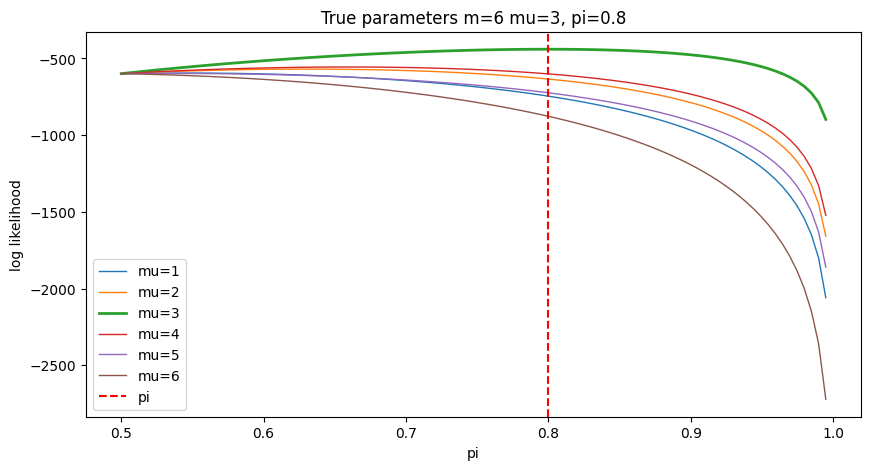

In [154]:
plot_log_likelihoods(m=M, mu=mu, pi=PI, u=u, nb_pi=100, data=xs, nb_sample=None)

In [158]:
%%time
for mu_prop in range(1, M + 1):
    f = lambda t: compute_log_likelihood(m=5, data=xs, pi=t, u_mu=u[mu_prop - 1])
    pi_hat, ll_pi = trichotomy_maximization(f, 0.5, 1, epsilon=1e-4)
    print(f"mu={mu_prop}, pi={pi_hat}, {ll_pi=}")


i=22
mu=1, pi=0.5000334142955358, ll_pi=-392.0427685926123
i=22
mu=2, pi=0.5000334142955358, ll_pi=-392.0335676338277
i=22
mu=3, pi=0.6855319915115363, ll_pi=-353.57321825136734
i=22
mu=4, pi=0.5000334142955358, ll_pi=-392.8218742025562
i=22
mu=5, pi=0.5000334142955358, ll_pi=-392.83663744590973
i=22
mu=6, pi=0.5000334142955358, ll_pi=-392.8456910851813
CPU times: user 582 ms, sys: 0 ns, total: 582 ms
Wall time: 584 ms


In [157]:
%%time
mu_hat, pi_hat_grid, ll_pi_grid = estimate_mu_pi_grid(m=5, data=xs, u=u)
print(f"Grid estimate {mu_hat=}, {pi_hat_grid=}, {ll_pi_grid=}")

/media/Data/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/notebooks/../src/god_model_estimator.py:189: RuntimeWarning: divide by zero encountered in log
  if weights is None:


Grid estimate mu_hat=3, pi_hat_grid=0.6868686868686869, ll_pi_grid=-353.5754363503452
CPU times: user 967 ms, sys: 0 ns, total: 967 ms
Wall time: 968 ms


0.90283203125

In [105]:
import cvxpy as cp
import numpy as np

# Assuming u, mu, xs, and M are defined appropriately

# Define the optimization variable
pi = cp.Variable(pos=True)

# Define the objective function
ll = cp.sum([
    cp.entr(cp.sum([
        pi**(M - d) * (1 - pi)**d * u[mu - 1, x - 1, d] for d in range(M + 1)]
    )) for x in xs])

objective = cp.Maximize(ll)

constraints = [0.5 <= pi, pi <= 1]

# Define the optimization problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Optimal value for pi
optimal_pi = pi.value

print("Optimal value for pi:", optimal_pi)


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
power(var3403, 4.0) @ power(1.0 + -var3403, 1.0)
power(var3403, 3.0) @ power(1.0 + -var3403, 2.0)
power(var3403, 2.0) @ power(1.0 + -var3403, 3.0)
power(var3403, 1.0) @ power(1.0 + -var3403, 4.0)
power(var3403, 4.0) @ power(1.0 + -var3403, 1.0)
power(var3403, 3.0) @ power(1.0 + -var3403, 2.0)
power(var3403, 2.0) @ power(1.0 + -var3403, 3.0)
power(var3403, 1.0) @ power(1.0 + -var3403, 4.0)
power(var3403, 4.0) @ power(1.0 + -var3403, 1.0)
power(var3403, 3.0) @ power(1.0 + -var3403, 2.0)
power(var3403, 2.0) @ power(1.0 + -var3403, 3.0)
power(var3403, 1.0) @ power(1.0 + -var3403, 4.0)
power(var3403, 4.0) @ power(1.0 + -var3403, 1.0)
power(var3403, 3.0) @ power(1.0 + -var3403, 2.0)
power(var3403, 2.0) @ power(1.0 + -var3403, 3.0)
power(var3403, 1.0) @ power(1.0 + -var3403, 4.0)
power(var3403, 4.0) @ power(1.0 + -var3403, 1.0)
power(var3403, 3.0) @ power(1.0 + -var3403, 2.0)
power(var3403, 2.0) @ power(1.0 + -var3403, 3.0)
power(var3403, 1.0) @ power(1.0 + -var3403, 4.0)

NameError: name 'result' is not defined